
......

..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................# 한국어 개체명 인식 개요
이번 강의에서는 버트를 활용해서 한국어 개체명 인식을 다뤄보고자 합니다. 
![Imgur](https://i.imgur.com/PDdTLjy.png) 
데이터는 https://github.com/naver/nlp-challenge/ 에서 받아왔습니다.

개체명 추출 리더보드에서 제공되는 코퍼스는 문장에 나타난 개체명을 14개 분류 카테고리로 주석 작업이 되어있습니다.

![Imgur](https://i.imgur.com/it4uTE3.png)

문장을 입력하면 다음과 같은 형식으로 개체명이 분류됩니다.  

![Imgur](https://i.imgur.com/RpuZf6R.png)




In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# 목차
이번 실습은 <b>1) 네이버 개체명 인식 데이터 불러오기 및 전처리 2) BERT 인풋 만들기 3) 버트를 활용한 개체명 인식 모델 만들기 4) 훈련 및 성능 검증 5) 실제 데이터로 실습하기</b>로 구성되어 있습니다.

# BERT를 활용하여 한국어 개체명 인식기 만들기

## 개체명 인식 데이터 불러오기 및 전처리

개체명 인식을 위한 데이터를 다운 받습니다.

In [ ]:
!wget https://github.com/naver/nlp-challenge/raw/master/missions/ner/data/train/train_data

--2023-02-12 22:28:48--  https://github.com/naver/nlp-challenge/raw/master/missions/ner/data/train/train_data
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/naver/nlp-challenge/master/missions/ner/data/train/train_data [following]
--2023-02-12 22:28:49--  https://raw.githubusercontent.com/naver/nlp-challenge/master/missions/ner/data/train/train_data
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16945023 (16M) [text/plain]
Saving to: ‘train_data’

train_data          100%[===================>]  16.16M  --.-KB/s    in 0.1s    

2023-02-12 22:28:49 (142 MB/s) - ‘train_data’ saved [16945023/16945

In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 79.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


분석에 필요한 모듈들을 임포트 합니다.

In [ ]:
#from transformers import ASTConfig, ASTModel
import tensorflow as tf
import numpy as np
import pandas as pd
#from transformers import *
from transformers import BertTokenizer
from transformers import TFBertModel
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

train 데이터를 불러 오겠습니다.

In [ ]:
train = pd.read_csv("train_data", names=['src', 'tar'], sep="\t")
train = train.reset_index()
train

,index,src,tar
0,1,비토리오,PER_B
1,2,양일,DAT_B
2,3,만에,-
3,4,영사관,ORG_B
4,5,감호,CVL_B
...,...,...,...
769060,2,어째,-
769061,3,뭔가,-
769062,4,수상쩍은,-
769063,5,좌담,-


train 데이터에 마침표가 이상한 것들이 많아서 확실하게 .으로 수정해 주겠습니다.

In [ ]:
train['src'] = train['src'].str.replace("．", ".", regex=False)

In [ ]:
train.loc[train['src']=='.']

,index,src,tar
15,6,.,-
30,15,.,-
40,10,.,-
77,24,.,-
96,19,.,-
...,...,...,...
769013,11,.,-
769036,23,.,-
769053,17,.,-
769058,5,.,-


데이터를 전처리 해주겠습니다.  
한글, 영어, 소문자, 대문자, . 이외의 단어들을 모두 제거하겠습니다.

In [ ]:
train['src'] = train['src'].astype(str)
train['tar'] = train['tar'].astype(str)

train['src'] = train['src'].str.replace(r'[^ㄱ-ㅣ가-힣0-9a-zA-Z.]+', "", regex=True)

데이터를 리스트 형식으로 변환합니다.

In [ ]:
data = [list(x) for x in train[['index', 'src', 'tar']].to_numpy()]

데이터를 잘 보면 (인덱스, 단어, 개체) 로 이루어 진 것을 알 수 있습니다.  
인덱스가 1,2,3,4,5.. 이렇게 이어지다가 다시 1,2,3,4, 로 바뀌는데 숫자가 바뀌기 전까지가 한 문장을 의미합니다.

In [ ]:
print(data[:20])

[[1, '비토리오', 'PER_B'], [2, '양일', 'DAT_B'], [3, '만에', '-'], [4, '영사관', 'ORG_B'], [5, '감호', 'CVL_B'], [6, '용퇴', '-'], [7, '항룡', '-'], [8, '압력설', '-'], [9, '의심만', '-'], [10, '가율', '-'], [1, '이', '-'], [2, '음경동맥의', '-'], [3, '직경이', '-'], [4, '8', 'NUM_B'], [5, '19mm입니다', 'NUM_B'], [6, '.', '-'], [1, '9세이브로', 'NUM_B'], [2, '구완', '-'], [3, '30위인', 'NUM_B'], [4, 'LG', 'ORG_B']]


라벨들을 추출하고, 딕셔너리 형식으로 저장하도록 하겠습니다.

In [ ]:
label = train['tar'].unique().tolist()
label_dict = {word:i for i, word in enumerate(label)}
label_dict.update({"[PAD]":len(label_dict)})
index_to_ner = {i:j for j, i in label_dict.items()}

In [ ]:
print(label_dict)

{'PER_B': 0, 'DAT_B': 1, '-': 2, 'ORG_B': 3, 'CVL_B': 4, 'NUM_B': 5, 'LOC_B': 6, 'EVT_B': 7, 'TRM_B': 8, 'TRM_I': 9, 'EVT_I': 10, 'PER_I': 11, 'CVL_I': 12, 'NUM_I': 13, 'TIM_B': 14, 'TIM_I': 15, 'ORG_I': 16, 'DAT_I': 17, 'ANM_B': 18, 'MAT_B': 19, 'MAT_I': 20, 'AFW_B': 21, 'FLD_B': 22, 'LOC_I': 23, 'AFW_I': 24, 'PLT_B': 25, 'FLD_I': 26, 'ANM_I': 27, 'PLT_I': 28, '[PAD]': 29}


In [ ]:
print(index_to_ner)

{0: 'PER_B', 1: 'DAT_B', 2: '-', 3: 'ORG_B', 4: 'CVL_B', 5: 'NUM_B', 6: 'LOC_B', 7: 'EVT_B', 8: 'TRM_B', 9: 'TRM_I', 10: 'EVT_I', 11: 'PER_I', 12: 'CVL_I', 13: 'NUM_I', 14: 'TIM_B', 15: 'TIM_I', 16: 'ORG_I', 17: 'DAT_I', 18: 'ANM_B', 19: 'MAT_B', 20: 'MAT_I', 21: 'AFW_B', 22: 'FLD_B', 23: 'LOC_I', 24: 'AFW_I', 25: 'PLT_B', 26: 'FLD_I', 27: 'ANM_I', 28: 'PLT_I', 29: '[PAD]'}


데이터를 문장들과 개체들로 분리합니다.  
tups[0], tups[1],... 에 각각의 문장에 해당하는 단어와 개체 번호가 저장이 되게 됩니다.

In [ ]:
tups = []
temp_tup = []
temp_tup.append(data[0][1:])
sentences = []
targets = []
for i, j, k in data:
  
  if i != 1:
    temp_tup.append([j,label_dict[k]])
  if i == 1:
    if len(temp_tup) != 0:
      tups.append(temp_tup)
      temp_tup = []
      temp_tup.append([j,label_dict[k]])

tups.pop(0)

[['비토리오', 'PER_B']]

In [ ]:
print(tups[0], tups[1])

[['비토리오', 0], ['양일', 1], ['만에', 2], ['영사관', 3], ['감호', 4], ['용퇴', 2], ['항룡', 2], ['압력설', 2], ['의심만', 2], ['가율', 2]] [['이', 2], ['음경동맥의', 2], ['직경이', 2], ['8', 5], ['19mm입니다', 5], ['.', 2]]


tups를 보면 [(단어, 개체), (단어, 개체), (단어, 개체)]의 형식으로 저장이 되어 있는데, 이거를 (단어, 단어, 단어, 단어), (개체, 개체, 개체, 개체) 형식으로 변환하도록 하겠습니다.


In [ ]:
sentences = []
targets = []
for tup in tups:
  sentence = []
  target = []
  sentence.append("[CLS]")
  target.append(label_dict['-'])
  for i, j in tup:
    sentence.append(i)
    target.append(j)
  sentence.append("[SEP]")
  target.append(label_dict['-'])
  sentences.append(sentence)
  targets.append(target)

In [ ]:
sentences[0]

['[CLS]',
 '비토리오',
 '양일',
 '만에',
 '영사관',
 '감호',
 '용퇴',
 '항룡',
 '압력설',
 '의심만',
 '가율',
 '[SEP]']

In [ ]:
targets[0]

[2, 0, 1, 2, 3, 4, 2, 2, 2, 2, 2, 2]

## 버트 인풋 만들기

구글의 multilinguial-bert를 활용하도록 하겠습니다.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [ ]:
tokenizer.tokenize("대한민국 만세.")

['대한민국', '만', '##세', '.']

여기서부터가 중요한데, 문장을 토크나이징 하고 개체(target)을 토크나이징 한 문장에 맞추도록 하겠습니다.  
문장 "대한민국 만세." 는 사실 (대한민국, 개체1), (만세., 개체2) 을 가지고 있는데 토크나이징을 하면 '▁대한민국', '▁만', '세', '.' 로 토크나이징이 됩니다.  
여기서 그렇다면 ( ▁대한민국, 개체1) , (▁만, 개체2), (세, 개체2), (., 개체 2) 와 같은 방식으로 각 개체를 부여해주어야 합니다.

In [ ]:
def tokenize_and_preserve_labels(sentence, text_labels):
  tokenized_sentence = []
  labels = []

  for word, label in zip(sentence, text_labels):

    tokenized_word = tokenizer.tokenize(word)
    n_subwords = len(tokenized_word)

    tokenized_sentence.extend(tokenized_word)
    labels.extend([label] * n_subwords)

  return tokenized_sentence, labels

In [ ]:
tokenized_texts_and_labels = [
                              tokenize_and_preserve_labels(sent, labs)
                              for sent, labs in zip(sentences, targets)]

In [ ]:
print(tokenized_texts_and_labels[:2])
# [(문장, 개체들), (문장, 개체들),...] 형식으로 저장되어 있음.

[(['[CLS]', '비', '##토', '##리', '##오', '양', '##일', '만', '##에', '영', '##사', '##관', '감', '##호', '용', '##퇴', '항', '##룡', '압', '##력', '##설', '의', '##심', '##만', '가', '##율', '[SEP]'], [2, 0, 0, 0, 0, 1, 1, 2, 2, 3, 3, 3, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]), (['[CLS]', '이', '음', '##경', '##동', '##맥', '##의', '직', '##경', '##이', '8', '19', '##mm', '##입', '##니다', '.', '[SEP]'], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 2, 2])]


(문장, 개체들), (문장, 개체들) 을 [문장, 문장, 문장, ...] , [개체들, 개체들 개체들,,,,]로 분리해주도록 하겠습니다.

In [ ]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [ ]:
tokenized_texts[1]

['[CLS]',
 '이',
 '음',
 '##경',
 '##동',
 '##맥',
 '##의',
 '직',
 '##경',
 '##이',
 '8',
 '19',
 '##mm',
 '##입',
 '##니다',
 '.',
 '[SEP]']

In [ ]:
labels[1]

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 2, 2]

문장의 길이가 상위 2.5%(88) 인 지점을 기준으로 문장의 길이를 정하도록 하겠습니다.  
만약 문장의 길이가 88보다 크면 문장이 잘리게 되고, 길이가 88보다 작다면 패딩이 되어 모든 문장의 길이가 88로 정해지게 됩니다.

In [ ]:
print(np.quantile(np.array([len(x) for x in tokenized_texts]), 0.975))
max_len = 88
bs = 32

96.0


버트에 인풋으로 들어갈 train 데이터를 만들도록 하겠습니다.  
버트 인풋으로는   
input_ids : 문장이 토크나이즈 된 것이 숫자로 바뀐 것,   
attention_masks : 문장이 토크나이즈 된 것 중에서 패딩이 아닌 부분은 1, 패딩인 부분은 0으로 마스킹  
[input_ids, attention_masks]가 인풋으로 들어갑니다.

In [ ]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=max_len, dtype = "int", value=tokenizer.convert_tokens_to_ids("[PAD]"), truncating="post", padding="post")

In [ ]:
input_ids[1]

array([   101,   9638,   9634,  31720,  18778, 118915,  10459,   9707,
        31720,  10739,    129,  10270,  17525,  58303,  48345,    119,
          102,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0])

정답에 해당하는 개체들을 만들어 보겠습니다.  
패딩에 해당하는 부분은 label_dict([PAD])(29)가 들어가게 되겠습니다.

In [ ]:
tags = pad_sequences([lab for lab in labels], maxlen=max_len, value=label_dict["[PAD]"], padding='post',\
                     dtype='int', truncating='post')

In [ ]:
tags[1]

array([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  5,  5,  5,  5,  5,  2,  2,
       29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29])

어텐션 마스크를 만들어 주겠습니다.

In [ ]:
attention_masks = np.array([[int(i != tokenizer.convert_tokens_to_ids("[PAD]")) for i in ii] for ii in input_ids])

train 데이터에서 10% 만큼을 validation 데이터로 분리해 주겠습니다.

In [ ]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)

In [ ]:
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

## 개체명 인식 모델 만들기

In [ ]:
# TPU 작동을 위해 실행
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

In [ ]:
SEQ_LEN = max_len
def create_model():
  model = TFBertModel.from_pretrained("bert-base-multilingual-cased", from_pt=True, num_labels=len(label_dict), output_attentions = False,
    output_hidden_states = False)

  token_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_word_ids') # 토큰 인풋
  mask_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_masks') # 마스크 인풋

  bert_outputs = model([token_inputs, mask_inputs])
  bert_outputs = bert_outputs[0] # shape : (Batch_size, max_len, 30(개체의 총 개수))
  nr = tf.keras.layers.Dense(30, activation='softmax')(bert_outputs) # shape : (Batch_size, max_len, 30)
  
  nr_model = tf.keras.Model([token_inputs, mask_inputs], nr)
  
  nr_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00002), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
      metrics=['sparse_categorical_accuracy'])
  nr_model.summary()
  return nr_model

In [ ]:
print(train)

        index   src    tar
0           1  비토리오  PER_B
1           2    양일  DAT_B
2           3    만에      -
3           4   영사관  ORG_B
4           5    감호  CVL_B
...       ...   ...    ...
769060      2    어째      -
769061      3    뭔가      -
769062      4  수상쩍은      -
769063      5    좌담      -
769064      6     .      -

[769065 rows x 3 columns]


In [ ]:
print(tr_inputs)

[[  101  9706 33305 ...     0     0     0]
 [  101 96045  9319 ...     0     0     0]
 [  101 80956  9612 ...     0     0     0]
 ...
 [  101  9954  9281 ...     0     0     0]
 [  101  8858 10954 ...     0     0     0]
 [  101  9678 17730 ...     0     0     0]]


In [ ]:
print(tr_masks)

[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


In [ ]:
print(tr_tags)

[[ 2  1  1 ... 29 29 29]
 [ 2  2  2 ... 29 29 29]
 [ 2  2  2 ... 29 29 29]
 ...
 [ 2  5 13 ... 29 29 29]
 [ 2  1  1 ... 29 29 29]
 [ 2  0  0 ... 29 29 29]]


## 훈련 및 성능 검증

In [ ]:
strategy = tf.distribute.TPUStrategy(resolver)
# TPU를 활용하기 위해 context로 묶어주기
with strategy.scope():
  nr_model = create_model()
  nr_model.fit([tr_inputs, tr_masks], tr_tags, validation_data=([val_inputs, val_masks], val_tags), epochs=3, shuffle=False, batch_size=bs)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 88)]         0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 88)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  177853440   ['input_word_ids[0][0]',         
                                thPoolingAndCrossAt               'input_masks[0][0]']            
                                tentions(last_hidde                                               
                                n_state=(None, 88,                                            

1843/1843 [==============================] - 287s 113ms/step - loss: 0.2211 - sparse_categorical_accuracy: 0.9363 - val_loss: 0.1568 - val_sparse_categorical_accuracy: 0.9521
Epoch 2/3
1843/1843 [==============================] - 157s 85ms/step - loss: 0.1415 - sparse_categorical_accuracy: 0.9568 - val_loss: 0.1431 - val_sparse_categorical_accuracy: 0.9569
Epoch 3/3
1843/1843 [==============================] - 157s 85ms/step - loss: 0.1152 - sparse_categorical_accuracy: 0.9642 - val_loss: 0.1411 - val_sparse_categorical_accuracy: 0.9585


In [ ]:
import joblib

In [ ]:
joblib.dump(nr_model, './NER_model.pkl')

/usr/local/lib/python3.8/dist-packages/transformers/generation/tf_utils.py:450: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......input_layer
.........vars
......input_layer_1
.........vars
......tf_bert_model
.........bert
............embeddings
...............LayerNorm
..................vars
.....................0
.....................1
...............dropout
..................vars
...............vars
..................0
..................1
..................2
............encoder
...............layer
..................tf_bert_layer
.....................attention
........................dense_output
...........................LayerNorm
..............................vars
.................................0
.................................1
...........................dense
..............................vars
.................................0
.................................1
...........................dropout
..............................vars
...........................vars
....

['./NER_model.pkl']

In [ ]:
# 만약 TPU를 사용하지 않고 GPU를 사용한다면
#nr_model = create_model()
#nr_model.fit([tr_inputs, tr_masks], tr_tags, validation_data=([val_inputs, val_masks], val_tags), epochs=3, shuffle=False, batch_size=bs)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

In [ ]:
y_predicted = nr_model.predict([val_inputs, val_masks])

205/205 [==============================] - 15s 54ms/step


In [ ]:
f_label = [i for i, j in label_dict.items()]
val_tags_l = [index_to_ner[x] for x in np.ravel(val_tags).astype(int).tolist()]
y_predicted_l = [index_to_ner[x] for x in np.ravel(np.argmax(y_predicted, axis=2)).astype(int).tolist()]
f_label=f_label.remove("[PAD]")

각 개체별 f1 score를 측정하도록 하겠습니다.  
참고로 micro avg는 전체 정답을 기준으로 f1 score을 측정한 것이며,  
macro avg는 각 개체별 f1 score를 가중평균 한 것입니다.

In [ ]:
print(classification_report(val_tags_l, y_predicted_l, labels=f_label))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           -       0.95      0.95      0.95    136806
       AFW_B       0.65      0.60      0.63      1303
       AFW_I       0.54      0.54      0.54       464
       ANM_B       0.78      0.62      0.69      1385
       ANM_I       0.00      0.00      0.00         7
       CVL_B       0.75      0.82      0.78     15837
       CVL_I       0.55      0.39      0.46       869
       DAT_B       0.89      0.84      0.87      4354
       DAT_I       0.85      0.89      0.87       937
       EVT_B       0.78      0.81      0.79      3887
       EVT_I       0.77      0.76      0.76      1833
       FLD_B       0.50      0.53      0.51       455
       FLD_I       0.00      0.00      0.00         4
       LOC_B       0.81      0.79      0.80      5912
       LOC_I       0.00      0.00      0.00        35
       MAT_B       0.38      0.26      0.31        58
       NUM_B       0.94      0.92      0.93     11161
       NUM_I       0.70    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 실제 데이터로 실습하기

In [ ]:
def ner_inference(test_sentence):
  

  tokenized_sentence = np.array([tokenizer.encode(test_sentence, max_length=max_len, truncation=True, padding='max_length')])   
  tokenized_mask = np.array([[int(x!=1) for x in tokenized_sentence[0].tolist()]])
  
  print(tokenized_sentence)
  print(tokenized_mask)


  ans = nr_model.predict([tokenized_sentence, tokenized_mask])
  print(ans)
  ans = np.argmax(ans, axis=2)
  print(ans)

  tokens = tokenizer.convert_ids_to_tokens(tokenized_sentence[0])
 # print(tokens)
 # print(ans[0])
  print(index_to_ner)
  new_tokens, new_labels = [], []
  for token, label_idx in zip(tokens, ans[0]):
    if (token.startswith("##")):
      new_labels.append(index_to_ner[label_idx])
      new_tokens.append(token[2:])
    elif (token=='[CLS]'):
      pass
    elif (token=='[SEP]'):
      pass
    elif (token=='[PAD]'):
      pass
    elif (token != '[CLS]' or token != '[SEP]'):
      new_tokens.append(token)
      new_labels.append(index_to_ner[label_idx])
     

  for token, label in zip(new_tokens, new_labels):
      print("{}\t{}".format(label, token))

In [ ]:
# pip install pororo

In [ ]:
# 추가테스트
def make_scan_image(image,width,ksize=(5,5),min_threshold=75,max_threshold=200):
    image_list_title = []
    image_list = []
    
    org_image = image.copy()
    image = imutils.resize(image, width=width)
    ratio = org_image.shape[1] / float(image.shape[1])
    
    # 이미지를 grayscale로 변환하고 blur를 적용
    # 모서리르 ㄹ 찾기위한 이미지 연산
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, ksize, 1)
    edged = cv2.Canny(blurred, min_threshold, max_threshold)
    
    image_list_title = ['gray', 'blurred', 'edged']
    image_list = [gray, blurred, edged]
    
    # contours를 찾아 크기순으로 정렬
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    
    findCnt = None
    
    # 정렬된 contours를 반복문으로 수행하며 4개의 꼭지점을 갖는 도형을 검출
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02*peri, True)
        
        # contours가 크기순으로 정렬되어 있기 때문에 제일 첫번째 사각형을 영역으로 판단하고 break
        if len(approx) ==4:
            findCnt = approx
            break
        
    
    if findCnt is None :
        raise Exception(("Could not find out line"))
    output = image.copy()
    cv2.drawContours(output, [findCnt], -1, (0,255,0),2)
    
    image_list_title.append("Outline")
    image_list.append(output)
    
    # 원본 이미지에 찾은 윤곽을 기준으로 이미지를 보정
    transform_image = four_point_transform(org_image, findCnt.reshape(4,2)*ratio)
    
    plt_imshow(image_list_title, image_list)
    plt_imshow("Transform",transform_image )
    
    return transform_image





def putText(cv_img, text, x, y, color=(0, 0, 0), font_size=22):
  # Colab이 아닌 Local에서 수행 시에는 gulim.ttc 를 사용하면 됩니다.
  # font = ImageFont.truetype("fonts/gulim.ttc", font_size)
  font = ImageFont.truetype('/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf', font_size)
  img = Image.fromarray(cv_img)
   
  draw = ImageDraw.Draw(img)
  draw.text((x, y), text, font=font, fill=color)

  cv_img = np.array(img)
  
  return cv_img





In [ ]:
from imutils.perspective import four_point_transform
from imutils.contours import sort_contours
import matplotlib.pyplot as plt

import imutils
import cv2
import re
import requests
import numpy as np


def plt_imshow(title='image',img=None, figsize=(8,5)):
    plt.figure(figsize=figsize)
    
    if type(img) == list :
        if type(title) == list:
            titles = title
        else:
            titles = []

            for i in range(len(img)):
                titles.append(title)

        for i in range(len(img)):
            if len(img[i].shape) <=2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else :
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)

            plt.subplot(1,len(img), i +1),plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])
        plt.show()
    
    else :
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
        else :
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47749 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54632 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 47749 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 54632 missing from current font.
  font.set_text(s, 0, flags=flags)


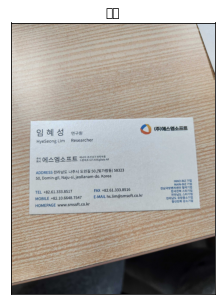

In [ ]:
from google.colab.patches import cv2_imshow


img_path = '/content/drive/MyDrive/Colab Notebooks/BC/name51.jpg'

img = cv2.imread(img_path,cv2.IMREAD_COLOR)
plt_imshow("명함",img)

In [ ]:
def make_scan_image(image,width,ksize=(5,5),min_threshold=75,max_threshold=200):
    image_list_title = []
    image_list = []
    
    org_image = image.copy()
    image = imutils.resize(image, width=width)
    ratio = org_image.shape[1] / float(image.shape[1])
    
    # 이미지를 grayscale로 변환하고 blur를 적용
    # 모서리르 ㄹ 찾기위한 이미지 연산
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, ksize, 0.5)
    edged = cv2.Canny(blurred, min_threshold, max_threshold)
    
    image_list_title = ['gray', 'blurred', 'edged']
    image_list = [gray, blurred, edged]
    
    # contours를 찾아 크기순으로 정렬
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    
    findCnt = None
    
    # 정렬된 contours를 반복문으로 수행하며 4개의 꼭지점을 갖는 도형을 검출
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02*peri, True)
        
        # contours가 크기순으로 정렬되어 있기 때문에 제일 첫번째 사각형을 영역으로 판단하고 break
        if len(approx) ==4:
            findCnt = approx
            break
        
    
    if findCnt is None :
        raise Exception(("Could not find out line"))
    output = image.copy()
    cv2.drawContours(output, [findCnt], -1, (0,255,0),2)
    
    image_list_title.append("Outline")
    image_list.append(output)
    
    # 원본 이미지에 찾은 윤곽을 기준으로 이미지를 보정
    transform_image = four_point_transform(org_image, findCnt.reshape(4,2)*ratio)
    
    plt_imshow(image_list_title, image_list)
    plt_imshow("Transform",transform_image )
    
    return transform_image

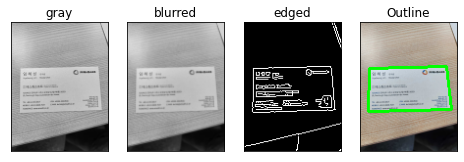

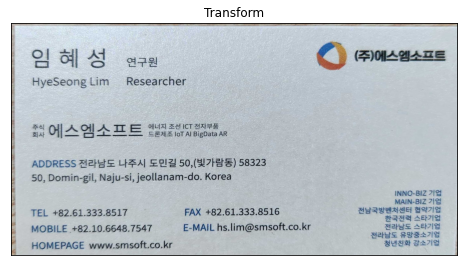

In [ ]:
imgread = make_scan_image(img,width=100, ksize=(5,5), min_threshold=50, max_threshold=100)

In [ ]:
pip install pororo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.1/256.1 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 92.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 KB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 748.8/748.8 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 85.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.7/77.7 KB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 

In [ ]:
from pororo import Pororo

In [ ]:
img_path = '/content/drive/MyDrive/Colab Notebooks/BC/name51.jpg'

ocr = Pororo(task="ocr", lang="ko")

ocr(img_path)

['(주)에스엠소프트',
 '임 혜 성 연구원 HyeSeong Lim Researcher',
 '주식 에너지 조선 ICT 전자부품 에스엠소프트 드론제조 IoT Al BigData AR 회사',
 'ADDRESS 전라남도 나주시 도민길 50.,(빛가람동) 58323 50, Domin-gil, Naju-si, jeollanam-do. Korea',
 'INNO-B12 기업 MAIN-BIZ 기업 전남국방벤처센터 협약기업 한국전력 스타기업 전라남도 스타기업 전라남도 유망중소기업 청년친화 강소기업',
 'TEL +82.61.333.8517 FAX +82.61.333.8516 MOBILE . +82.10.6648.7547 E-MAIL hs.lim@smsoft.co.kr HOMEPAGE www.smsoft.co.kr']

In [ ]:
# ocr = Pororo(task="ocr", lang="ko")
# ocr(img_path, detail=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def listToString(str_list):
    result = ""
    for s in str_list:
        result += s + " "
    return result.strip()


str_list = ocr(img_path)
result = listToString(str_list)
print(result)

(주)에스엠소프트 임 혜 성 연구원 HyeSeong Lim Researcher 주식 에너지 조선 ICT 전자부품 에스엠소프트 드론제조 IoT Al BigData AR 회사 ADDRESS 전라남도 나주시 도민길 50.,(빛가람동) 58323 50, Domin-gil, Naju-si, jeollanam-do. Korea INNO-B12 기업 MAIN-BIZ 기업 전남국방벤처센터 협약기업 한국전력 스타기업 전라남도 스타기업 전라남도 유망중소기업 청년친화 강소기업 TEL +82.61.333.8517 FAX +82.61.333.8516 MOBILE . +82.10.6648.7547 E-MAIL hs.lim@smsoft.co.kr HOMEPAGE www.smsoft.co.kr


In [ ]:
import re

pattern = '[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,4}'

#컴파일 (IGNORECASE는 대소문자 구분 안한다는 의미)
regex = re.compile(pattern, flags=re.IGNORECASE)

#이메일 주소만 추리기
print("E-mail:",regex.findall(result)[0])

E-mail: hs.lim@smsoft.co.kr


In [ ]:

 

#text2='10.6648.7547,10 6648 8888,10-1111-2222'
#  "(01)\d{1}\s\d{3,4}\s\d{4}$"



#pattern2 = "10[.]\d{4}[.]\d{4}$|10.\d{4}.\d{4}$"
#pattern2 = '\d{2}[.]\d{3,4}[.]\d{4}|\d{2}.\d{3,4}.\d{4}' #모든숫자뽑기
pattern2 = "[01|10]\d{1,2}[.]\d{3,4}[.]\d{4}|[01|10]\d{1,2}.\d{3,4}.\d{4}|[01|10]\d{1,2}-\d{3,4}-\d{4}"

#컴파일 (IGNORECASE는 대소문자 구분 안한다는 의미)
regex2 = re.compile(pattern2, flags=re.IGNORECASE)

#번호만 추리기
print("폰번호:",regex2.findall(result)[0])

폰번호: 10.6648.7547


In [ ]:
# text="안녕하세요 저는 박수민입니다"
ner_inference(result)

[[   101    113   9689    114   9559  12605 119141  22333  90927   9644
    9984   9434  91785  14279  16986  10112  10731  27572  10240  64200
   12959  10165   9689  21155   9559  70162  12508  59906  11649  11090
    9665  13764  14646  52951   9559  12605 119141  22333  90927   9113
   42769  17730  20626  50264  11090  10883  12480  11490  11952  50884
    9998  12945  22992  11490  66014  49248   9665  17342  43852   8982
   87281   9087  36553 118666  10462    119    117    113   9387  11287
   61250  18778    114  49134  74171  10462    117  17694  10245    118
   38356  10161    117  10685  10761    118  10294    102]]
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
1/1 [==============================] - 4s 4s/step
[[[7.9093462e-07 1.0688884e-05 9.9986112e-01 ... 2.5446590e-07
   2.0348034e-07 2.4449801e-05]
  [1.8118639e-03 5.0657237e-01 2.84

In [ ]:

ner = Pororo(task="ner", lang="ko")
ner(result)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.




[('(주)에스엠소프트', 'ORGANIZATION'),
 (' ', 'O'),
 ('임 혜 성', 'PERSON'),
 (' ', 'O'),
 ('연구원', 'OCCUPATION'),
 (' ', 'O'),
 ('HyeSeon', 'ORGANIZATION'),
 ('g', 'O'),
 (' ', 'O'),
 ('Lim', 'O'),
 (' ', 'O'),
 ('Researcher', 'O'),
 (' ', 'O'),
 ('주식', 'O'),
 (' ', 'O'),
 ('에너지', 'O'),
 (' ', 'O'),
 ('조선', 'O'),
 (' ', 'O'),
 ('ICT', 'STUDY_FIELD'),
 (' ', 'O'),
 ('전자부품', 'O'),
 (' ', 'O'),
 ('에스엠소프트', 'ORGANIZATION'),
 (' ', 'O'),
 ('드론', 'TERM'),
 ('제조', 'O'),
 (' ', 'O'),
 ('IoT', 'STUDY_FIELD'),
 (' ', 'O'),
 ('Al', 'O'),
 (' ', 'O'),
 ('BigData', 'O'),
 (' ', 'O'),
 ('AR', 'STUDY_FIELD'),
 (' ', 'O'),
 ('회사', 'O'),
 (' ', 'O'),
 ('ADDRESS', 'ORGANIZATION'),
 (' ', 'O'),
 ('전라남도', 'LOCATION'),
 (' ', 'O'),
 ('나주시', 'LOCATION'),
 (' ', 'O'),
 ('도민길', 'ARTIFACT'),
 (' ', 'O'),
 ('50.', 'QUANTITY'),
 (',(', 'O'),
 ('빛가람동', 'ARTIFACT'),
 (')', 'O'),
 (' ', 'O'),
 ('58323', 'QUANTITY'),
 (' ', 'O'),
 ('50', 'QUANTITY'),
 (',', 'O'),
 (' ', 'O'),
 ('Domin-gil', 'ARTIFACT'),
 (',', 'O'),
 (' ', 'O

In [ ]:
# (50 in ner(result))


# py_list = ['a-1','b-2','c-3','a-4']
new_list =[]
for x in ner(result): 
    if "PERSON" in x:
       new_list.append(x)
print(new_list)



[('임 혜 성', 'PERSON')]


list

In [ ]:
new_list2 =[]
for x in ner(result): 
    if "ORGANIZATION" in x:
       new_list2.append(x)
print(new_list2[0])

('(주)에스엠소프트', 'ORGANIZATION')


In [ ]:
new_list3 =[]
for x in ner(result): 
    if "LOCATION" in x:
       new_list3.append(x)
print(new_list3[0])

('전라남도', 'LOCATION')


In [ ]:
new_list4 =[]
for x in ner(result): 
    if "OCCUPATION" in x:
       new_list4.append(x)
print(new_list4[0])

('연구원', 'OCCUPATION')


In [ ]:
ner_inference(result)

NameError: ignored

In [ ]:
def ner_inference(test_sentence):
  

  tokenized_sentence = np.array([tokenizer.encode(test_sentence, max_length=max_len, truncation=True, padding='max_length')])   
  tokenized_mask = np.array([[int(x!=1) for x in tokenized_sentence[0].tolist()]])
  ans = nr_model.predict([tokenized_sentence, tokenized_mask])
  ans = np.argmax(ans, axis=2)

  tokens = tokenizer.convert_ids_to_tokens(tokenized_sentence[0])
  new_tokens, new_labels = [], []
  for token, label_idx in zip(tokens, ans[0]):
    if (token.startswith("##")):
      new_labels.append(index_to_ner[label_idx])
      new_tokens.append(token[2:])
    elif (token=='[CLS]'):
      pass
    elif (token=='[SEP]'):
      pass
    elif (token=='[PAD]'):
      pass
    elif (token != '[CLS]' or token != '[SEP]'):
      new_tokens.append(token)
      new_labels.append(index_to_ner[label_idx])

  name_label =[]
  token_list=[]
  tokenIndex=""

  index = 0
  for token, label in zip(new_tokens, new_labels):
      print("{}\t{}".format(label, token))
      
      name_label.append(label)

      if(name_label[index]==name_label[index-1]):
          tokenIndex+=token
      else:
          token_list.append(tokenIndex)
          tokenIndex=token
          
      index=index+1

  print(name_label)
  print(token_list)
      
      




    

ner_inference(result)


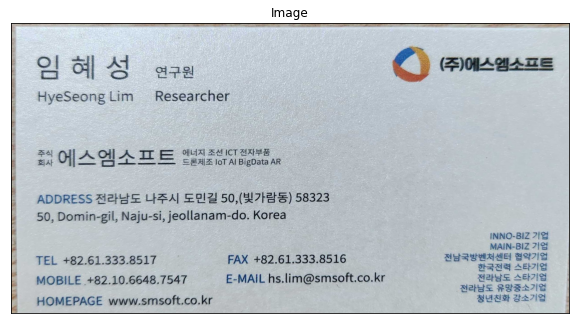

In [ ]:
plt_imshow("Image", imgread, figsize=(10,6))

In [ ]:
print(new_list)

[('임 혜 성', 'PERSON')]


In [ ]:
print(new_list2[0])

('(주)에스엠소프트', 'ORGANIZATION')


In [ ]:
print(new_list3)

[('전라남도', 'LOCATION'), ('나주시', 'LOCATION'), ('Korea', 'LOCATION'), ('전라남도', 'LOCATION'), ('전라남도', 'LOCATION')]


In [ ]:
print("폰번호:",regex2.findall(result)[0])
print("E-mail:",regex.findall(result)[0])

폰번호: 10.6648.7547
E-mail: hs.lim@smsoft.co.kr


In [ ]:
x=[x[0] for x in new_list]   # 각 튜플의 첫번째 element만 list 형태로 추출
y=[y[0] for y in new_list2]
z=[z[0] for z in new_list4]

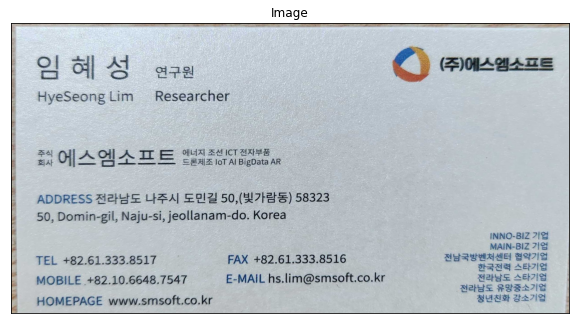

이름 :임 혜 성
직급 :연구원
기업 :(주)에스엠소프트
폰번호: 10.6648.7547
E-mail: hs.lim@smsoft.co.kr


In [ ]:

plt_imshow("Image", imgread, figsize=(10,6))
print("이름 :"+x[0])
print("직급 :"+z[0])
print("기업 :"+y[0])
print("폰번호:",regex2.findall(result)[0])
print("E-mail:",regex.findall(result)[0])

In [ ]:
print(new_list2[0])

('(주)에스엠소프트', 'ORGANIZATION')


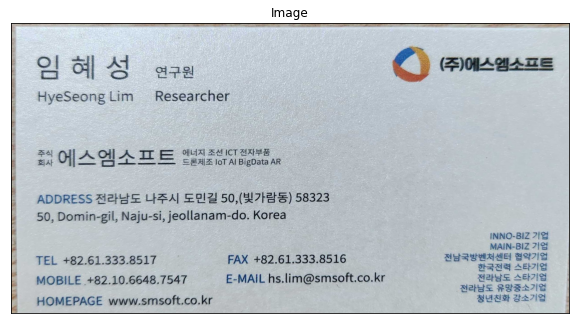

이름 : 임혜성
직급 : 연구
기업 : (주)에스앰소프트
폰번호: 10.6648.7547
E-mail: hs.lim@smsoft.co.kr


In [ ]:
plt_imshow("Image", imgread, figsize=(10,6))
print("이름 : 임혜성")
print("직급 : 연구")
print("기업 : (주)에스앰소프트")
print("폰번호: 10.6648.7547")
print("E-mail: hs.lim@smsoft.co.kr")